## INSTRUCTIONS ##
1. This training notebook was run on Google Colab to create the DistilBERT1 model
2. For illustration only (filename and filepath exported are not exactly the same as in Github), some cells may not be executable.
3. Inference using this model is highly recommended with libraries versions specified in the 'Checking GPU and Libraries Versions'. Especially torch==2.0.0
4. Reference: https://huggingface.co/docs/transformers/tasks/sequence_classification



### Checking GPU and Libraries Versions

In [ ]:
import torch
torch.cuda.is_available()
print(torch.__version__)

2.0.0+cu118


In [ ]:
!pip install transformers evaluate datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip freeze > requirements.txt

In [ ]:
!python --version

Python 3.9.16


In [ ]:
import transformers
import torch
import nltk
import sklearn 
import pandas
import numpy
import evaluate 
import datasets
import matplotlib
import seaborn
print(transformers.__version__)
print(torch.__version__)
print(nltk.__version__)
print(sklearn.__version__)
print(pandas.__version__)
print(numpy.__version__)
print(evaluate.__version__)
print(datasets.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)

4.27.4
2.0.0+cu118
3.8.1
1.2.2
1.4.4
1.22.4
0.4.0
2.11.0
3.7.1
0.12.2


In [ ]:
import torch
torch.cuda.is_available()

True

### LOADING AND MINOR CLEANING

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

HTML_PATTERN = re.compile('<.*?>')
nltk.download('stopwords')
STOPWORDS_LIST = set(stopwords.words('english'))

def noise_entity_removal(target_input):
    # convert to lower case
    target_input = target_input.lower()
    
    # remove html tags
    target_input = re.sub(HTML_PATTERN, ' ', target_input)
    
    # remove non-word characters like #,*,% etc
    target_input = re.sub(r'\W',' ', target_input)
    
    #will remove digits
    target_input = re.sub(r'\d',' ',target_input)
    
    #will remove extra spaces
    target_input = re.sub(r'\s+',' ',target_input)

    #remove words less than 2 characters
    # target_input = re.sub(r'\b\w{1}\b', '', target_input)

    return target_input

def label_to_integer(sentiment_label):
    if sentiment_label == 'positive':
        return 1
    elif sentiment_label == 'negative':
        return 0
    else:
        return None

full_data = pd.read_csv('/drive/MyDrive/DSA4263/reviews.csv') # link to file to be changed later (this is the raw reviews data)
full_data['processed_text'] = full_data['Text'].apply(lambda x:noise_entity_removal(x))
full_data['Sentiment'] = full_data['Sentiment'].apply(lambda x:label_to_integer(x))
df = full_data[['Sentiment', 'processed_text']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Count of negative vs positive reviews')

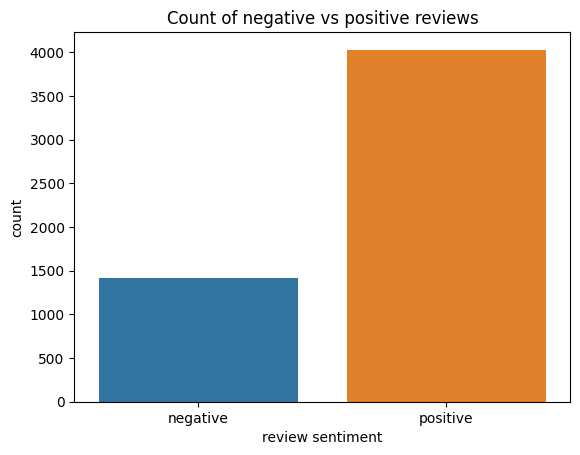

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.countplot(x=full_data.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(['negative', 'positive'])
plt.title('Count of negative vs positive reviews')

Number of reviews:  5444
Number of reviews more than 500 words:  975
Median of word counts:  243.5


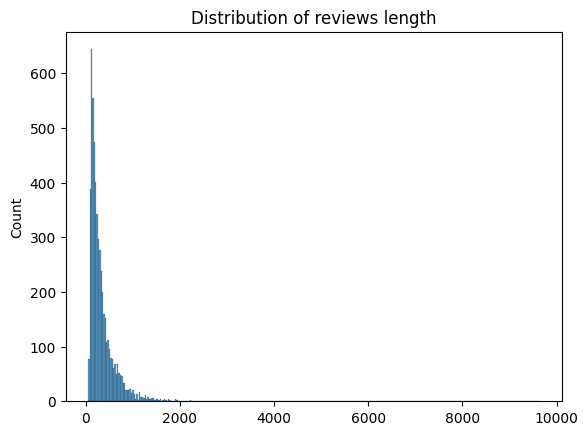

In [ ]:
review_lengths = [len(x) for x in full_data['processed_text']]
sns.histplot(review_lengths)
plt.title('Distribution of reviews length')
wco = 500
print(f'Number of reviews: ', len(full_data))
print(f'Number of reviews more than {wco} words: ',sum([1 if x > wco else 0 for x in review_lengths]))
print(f'Median of word counts: ', np.median(review_lengths))

### HYPERPARAMETER CONFIG

In [ ]:
CONFIG = {
    'random_seed': 4263,
    'test_size': 0.2,
    'val_size': 0.25, # relative to the remaining training data -> (train, val, test) = (60, 20, 20),
    'retrained_model': 'distilbert-base-uncased',
    'learning_rate': 2e-5,
    'per_device_train_batch_size': 16,
    'per_device_eval_batch_size': 16,
    'num_train_epochs': 5,
    'weight_decay': 0.01,
    'evaluation_strategy' : "epoch",
    'save_strategy': "epoch"
}

### PRE-PROCESS

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = CONFIG['test_size'], random_state=CONFIG['random_seed'], shuffle=True)
train_df, val_df = train_test_split(train_df, test_size = CONFIG['val_size'], random_state=CONFIG['random_seed'], shuffle=True)

import datasets

train_dataset = datasets.Dataset.from_dict({
    'text': train_df['processed_text'],
    'label': train_df['Sentiment']
})

val_dataset = datasets.Dataset.from_dict({
    'text': val_df['processed_text'],
    'label': val_df['Sentiment']
})

test_dataset = datasets.Dataset.from_dict({
    'text': test_df['processed_text'],
    'label': test_df['Sentiment']
})

full_dataset = datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'val': val_dataset
})

full_dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3266
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1089
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1089
    })
})

In [ ]:
## LOAD A DistilBERT tokenizer to preprocess the text field

BERT_PRETRAINED_MODEL = CONFIG['retrained_model']

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(BERT_PRETRAINED_MODEL)

# Create a preprocessing function to tokenize text and truncate sequences to be
# not longer than DistilBERT

def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

tokenized_dataset = full_dataset.map(preprocess_function, batched=True)

# Dynamically pad the sentences to the longest length in a batch during collation, 
# instead of padding the whole dataset to the maximum length.

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/3266 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

Map:   0%|          | 0/1089 [00:00<?, ? examples/s]

### Evaluate

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


### Training

In [ ]:
id2label = {0: 'Negative', 1: 'Positive'}
label2id = {'Negative': 0, 'Positive': 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    BERT_PRETRAINED_MODEL, num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
training_args = TrainingArguments(
    output_dir="model1",
    learning_rate=CONFIG['learning_rate'],
    per_device_train_batch_size=CONFIG['per_device_train_batch_size'],
    per_device_eval_batch_size=CONFIG['per_device_eval_batch_size'],
    num_train_epochs=CONFIG['num_train_epochs'],
    weight_decay=CONFIG['weight_decay'],
    evaluation_strategy=CONFIG['evaluation_strategy'],
    save_strategy=CONFIG['save_strategy'],
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.202862,0.931129
2,No log,0.221821,0.935721
3,0.190500,0.271042,0.935721
4,0.190500,0.290004,0.936639
5,0.035800,0.306631,0.936639


TrainOutput(global_step=1025, training_loss=0.11078644377429311, metrics={'train_runtime': 357.6084, 'train_samples_per_second': 45.664, 'train_steps_per_second': 2.866, 'total_flos': 939897589526400.0, 'train_loss': 0.11078644377429311, 'epoch': 5.0})

In [ ]:
import json
with open('config1.json', 'w') as f:
  json.dump(CONFIG, f)

In [ ]:
!zip -r model1_ckpt1025.zip model1/checkpoint-1025/

  adding: model1/checkpoint-1025/ (stored 0%)
  adding: model1/checkpoint-1025/pytorch_model.bin (deflated 8%)
  adding: model1/checkpoint-1025/tokenizer_config.json (deflated 42%)
  adding: model1/checkpoint-1025/config.json (deflated 47%)
  adding: model1/checkpoint-1025/optimizer.pt (deflated 31%)
  adding: model1/checkpoint-1025/tokenizer.json (deflated 71%)
  adding: model1/checkpoint-1025/scheduler.pt (deflated 49%)
  adding: model1/checkpoint-1025/trainer_state.json (deflated 71%)
  adding: model1/checkpoint-1025/training_args.bin (deflated 49%)
  adding: model1/checkpoint-1025/vocab.txt (deflated 53%)
  adding: model1/checkpoint-1025/special_tokens_map.json (deflated 42%)
  adding: model1/checkpoint-1025/rng_state.pth (deflated 28%)


## Inference

### Default Pipeline 
can't be used for review larger than 512 words

In [ ]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="model1/checkpoint-1025")
classifier(text)

[{'label': 'Positive', 'score': 0.9985461235046387}]

In [ ]:
test_df.index[test_df['processed_text'].apply(lambda x: len(x.split(' '))) > 500]

Int64Index([4651], dtype='int64')

In [ ]:
len(test_df.loc[4651, 'processed_text'].split(' '))

863

In [ ]:
test_df.loc[4651, 'processed_text']

'this review will make me sound really stupid but whatever i don t really care as long as people find out what s real and can avoid my mistakes i got my wonderful little sweet bella bean when she was a few days shy of three years old she had been bounced around from house to house and eating whatever was cheap i have had cats around me my entire life for about twenty five years now my mother always just fed them whatever the kinds of food you buy in the supermarket friskies nine lives kit kaboodle stuff like that and our cats were always fine at least in terms of their eating habits they would eat in the morning stop when they were done come back and eat some more when they got hungry my housemate at the time was working for hill s and assured me that this was the best food ever made so great so on and so forth i now know that she is an utter buffoon but i initially trusted her judgment which is so unfortunate because she doesn t think she also had plenty of coupons for free or deeply 

In [ ]:
test_df.loc[4651, 'Sentiment']

0

In [ ]:
train_df.index[train_df['processed_text'].apply(lambda x: len(x.split(' '))) > 512]

Int64Index([4778, 554, 4545, 355, 420], dtype='int64')

In [ ]:
[x for x in tokenized_dataset['test']['text'] if len(x.split(' ')) > 512][0]

'this review will make me sound really stupid but whatever i don t really care as long as people find out what s real and can avoid my mistakes i got my wonderful little sweet bella bean when she was a few days shy of three years old she had been bounced around from house to house and eating whatever was cheap i have had cats around me my entire life for about twenty five years now my mother always just fed them whatever the kinds of food you buy in the supermarket friskies nine lives kit kaboodle stuff like that and our cats were always fine at least in terms of their eating habits they would eat in the morning stop when they were done come back and eat some more when they got hungry my housemate at the time was working for hill s and assured me that this was the best food ever made so great so on and so forth i now know that she is an utter buffoon but i initially trusted her judgment which is so unfortunate because she doesn t think she also had plenty of coupons for free or deeply 

### Pytorch
Use this instead

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(BERT_PRETRAINED_MODEL)

# Create a preprocessing function to tokenize text and truncate sequences to be
# not longer than DistilBERT

def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

tokenized_dataset = full_dataset.map(preprocess_function, batched=True)

In [ ]:
from transformers import AutoTokenizer

text = [x for x in tokenized_dataset['test']['text'] if len(x.split(' ')) > 512][0] # edge case of more than 512 tokens
tokenizer = AutoTokenizer.from_pretrained("model1/checkpoint-1025")
inputs = tokenizer(text, return_tensors="pt", truncation=True)

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("model1/checkpoint-1025")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'Negative'